# 위스콘신 유방암 예측 예제

## 1. Dataset & Module

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# xgboost Model 사용
import xgboost as xgb
from xgboost import plot_importance

In [5]:
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label

In [6]:
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


## 2. EDA

### (1) Label값 확인하기

In [7]:
dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [8]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

### Result
- 0 : malignant (악성)
- 1 : benign (양성)

## 3. Train / Test Data 분할
- train data 는 80% , test data 는 20%로 분할

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

In [10]:
X_train.shape , X_test.shape

((455, 30), (114, 30))

## 4. Train/ Test Data를 DMatrix로 변환

In [11]:
dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

## 5. XGBoost Modeling
- 'max_depth' 
    - 트리 최대 깊이 
- 'eta' 
    - 학습률
- 'objective':'binary:logistic'
    - 예제 data가 이진분류이므로 objective Function으로 이진 로지스틱 사용
- 'eval_metric':'logloss'
    - 오류함수의 평가 성능 지표
- 'early_stoppings'
    - 더 이상 지표 개선이 없는 경우 중간에 빠져나옴
- num_rounds
    - 부스팅 반복 횟수

In [12]:
# hyper parameter 설정
params={
    'max_depth':3,
    'eta' : 0.1,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds=400

In [13]:
# 반복마다 evals에 표시된 dataset에 대한 평가지표 결과 출력
# train dataset => train & test dataset => eval
wlist=[(dtrain,'train'), (dtest,'eval')]

# hyper parameter 
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[17:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss

### Result
- train-logloss & eval-logloss 가 지속적으로 감소

## 6. 예측
- predict값 > 0.5 => 악성 (1)
- predict값 <= 0.5 => 양성 (0)

In [14]:
pred_probs=xgb_model.predict(dtest)
# predict 값을 10개만 표시
np.round(pred_probs[:10],3)

array([0.934, 0.003, 0.91 , 0.094, 0.993, 1.   , 1.   , 0.999, 0.997,
       0.   ], dtype=float32)

In [15]:
# 0.5 초과면 악성, 이하면 양성 
preds=[1 if x>0.5 else 0 for x in pred_probs]
# 수행결과를 10개만 표시
preds[:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]

## 7. 성능 평가

In [22]:
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
# 종류별로 평가하는 function
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    # ROC_AUC 추가
    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차행렬: \n', confusion)
    print('정확도: ', np.round(accuracy,3), "정밀도: ", np.round(precision,3), '재현율: ', np.round(recall,3), 'f1: ', np.round(f1,3),'AUC: ', np.round(roc_auc,3))

In [23]:
get_clf_eval(y_test,preds, pred_probs)

오차행렬: 
 [[35  2]
 [ 1 76]]
정확도:  0.974 정밀도:  0.974 재현율:  0.987 f1:  0.981 AUC:  0.995


## 8. Feature Importance Visualization
- F1 Score 기반으로 Feature Importance 시각화

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

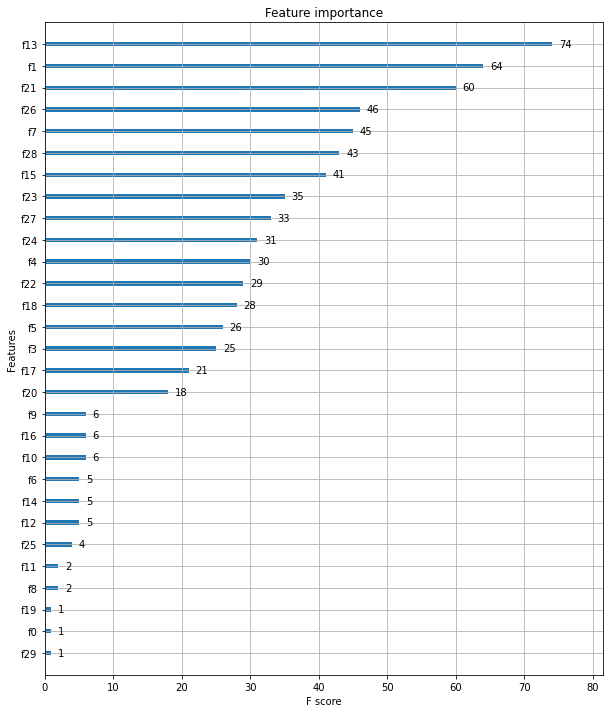

In [27]:
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)